In [304]:
import numpy as np
import copy
from sklearn.neural_network import MLPRegressor
from numpy.random import *
from operator import itemgetter

# 1.InputFieldData

In [305]:
def sortPosInfo(pos_list_with_num,info_name):
    np_pos_list_with_num = np.asarray(pos_list_with_num)
    sorted_np_pos_list_with_num = np.array(sorted(np_pos_list_with_num,key=itemgetter(1)))
    pos_list = []
    for pos_info in sorted_np_pos_list_with_num:
        pos_list.append(pos_info[0])
    print("{0} = {1}".format(info_name,pos_list))
    return pos_list

In [306]:
def inputFieldData(text_path):
    f = open(text_path)
    line = f.readline()
    line_count = 1
    field_size = int(len(line) / 2)
    field = np.empty((0,field_size),int)
    agents_pos_list = []
    goal_pos_list = []
    while line:
        last_idx = line.find("\n")
        field_row = np.array([])
        for i in range(0,last_idx,2):
            field_row = np.append(field_row,int(line[i]))
            if int(line[i]) % 2 == 0 and int(line[i]) != 0:
                agent_data = np.array([np.array([line_count-1,int(i/2)]),int(line[i])])
                agents_pos_list.append(agent_data)
            if int(line[i]) % 2 == 1 and int(line[i]) != 1:
                goal_data = np.array([np.array([line_count-1,int(i/2)]),int(line[i])])
                goal_pos_list.append(goal_data)
        field = np.append(field,np.array([field_row]),axis=0)
        line = f.readline()
        line_count += 1
    f.close()
    print("init field = \n {0}".format(field))
    agents_pos_list = sortPosInfo(agents_pos_list,"agents_pos_list")
    goal_pos_list = sortPosInfo(goal_pos_list,"goal_pos_list")
    return field,agents_pos_list,goal_pos_list

In [307]:
init_field,agents_pos_list,goal_pos_list = inputFieldData("demoField.txt")
field_row = len(init_field[0])
field_col = len(init_field)

init field = 
 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  3.  0.  0.  0.  7.  0.  4.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  0.  0.  1.  0.  1.]
 [ 1.  5.  6.  0.  1.  0.  0.  2.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
agents_pos_list = [array([4, 7]), array([1, 7]), array([4, 2])]
goal_pos_list = [array([1, 1]), array([4, 1]), array([1, 5])]


# 2.DecideActions

In [308]:
def moveToNextPos(pos,action):
    if action == 0:
        next_pos = [pos[0]-1,pos[1]]
    elif action == 1:
        next_pos = [pos[0],pos[1]+1]
    elif action == 2:
        next_pos = [pos[0]+1,pos[1]]
    elif action== 3:
        next_pos = [pos[0],pos[1]-1]
    else:
        next_pos = [pos[0],pos[1]]
    return next_pos

In [309]:
def buildNetwork(X_train,y_train):
    clf = MLPRegressor(solver="adam",random_state=1,max_iter=1000,hidden_layer_sizes=(20,50,10))
    print("X_train.shape = {0} , y_train.shape = {1}".format(X_train.shape,y_train.shape))
    clf.fit(X_train,y_train)
    return clf

In [310]:
def checkNextField(action_data,poses,pred_actions,field,agent_num):
    next_poses = [moveToNextPos(poses[i],pred_actions[i]) for i in range(len(poses))]
    next_pos = next_poses[agent_num]
    action_flag = True
    #行動先が行動可能かどうか判定
    if field[next_pos[0],next_pos[1]] != 1: #行動先が壁でないとき
        for j in range(len(next_poses)):
            #エージェントの向きと真逆の方向へは移動できない
            if action_data:
                prev_action = action_data[-1][j]
                pred_action = pred_actions[j]
                if (prev_action == 0 and pred_action == 2) or (prev_action == 1 and pred_action == 3) or (prev_action == 2 and pred_action == 0) or (prev_action == 3 and pred_action == 1):
                    action_flag = False
#             #次の目的地設定後1ステップ目は前回の移動方向を参照して真逆の方向への移動ができない制限を加える必要がある
            else:
                pred_action = pred_actions[j]
                if all_best_action_data:
                    prev_action = all_best_action_data[-1][-1][j]
                    if (prev_action == 0 and pred_action == 2) or (prev_action == 1 and pred_action == 3) or (prev_action == 2 and pred_action == 0) or (prev_action == 3 and pred_action == 1):
#                         print("prev_action = {0}, pred_action = {1}, j = {2}".format(prev_action,pred_action,j))
                        action_flag = False
            #行動先に先約があるとき
            if agent_num == j: continue
            if next_poses[agent_num] == next_poses[j]:
                action_flag = False
            #他エージェントと交差するとき
            if next_poses[agent_num] == poses[j] and next_poses[j] == poses[agent_num]:
                action_flag = False
    else:
        action_flag = False
    return action_flag

In [311]:
def checkAchievingGoal(poses,goal_flags):
    for i in range(len(poses)):
        if poses[i] == goal_pos_list[i].tolist():
            goal_flags[i] = True
    return goal_flags

In [312]:
def checkActions(action_data,pred_actions,field,poses,goal_flags):
    next_poses = []
    exit_flag = False
    for i in range(len(pred_actions)):
        next_poses.append(moveToNextPos(poses[i],pred_actions[i]))
        goal_flags = checkAchievingGoal(poses,goal_flags)
        if goal_flags[i]:
            pred_actions[i] = 4
    for i in range(len(next_poses)):
        if goal_flags[i]:
            continue
        #行動先が行動可能かどうか判定
        action_flag = checkNextField(action_data,poses,pred_actions,field,i)
        #行動不可能なとき，注目するエージェントの行動先を変更
        cnt = 0
        while action_flag == False:
            pred_actions[i] = int(pred_actions[i] + rand() * 3 + 1) % 4
            action_flag = checkNextField(action_data,poses,pred_actions,field,i)
            cnt += 1
            if cnt > 100:
                exit_flag = True
                break
    goal_flags = checkAchievingGoal(poses,goal_flags)
    for i in range(len(goal_flags)):
        if goal_flags[i]:
            pred_actions[i] = 4 #停止
    return pred_actions,exit_flag

In [313]:
def predictActions(clf,field):
    X_test = np.asarray(field).reshape(1,field_row*field_col)
    actions = clf.predict(X_test)[0]
    for i in range(len(actions)):
        actions[i] = int(actions[i])
        
    if rand() < 0.2:
        for i in range(len(actions)):
            actions[i] = int(actions[i] + rand() * 3 + 1) % 4
    return actions

In [314]:
#特殊地点：エージェントのゴール地点
def updateField(poses,next_poses,field):
    for i in range(len(agents_pos_list)):
        pos = poses[i]
        next_pos = next_poses[i]
        #エージェントがいずれかの方向に進行する場合
        if pos != next_pos:
            #現在いる地点が特殊地点でないとき
            if field[pos[0],pos[1]] % 2 == 0:
                field[pos[0],pos[1]] = 0
            #現在いる地点が特殊地点のときは現在地の値は変更しない
            
            #遷移先が特殊地点でないとき
            if field[next_pos[0],next_pos[1]] % 2 == 0:
                field[next_pos[0],next_pos[1]] = i*2 + 2
            #遷移先が特殊地点のときは遷移先の値は変更しない

In [315]:
def printFieldData(field_data,action_data):
    for i in range(len(field_data)):
        print(field_data[i])
        print(action_data[i])
    print("--------------------------------------------------")

In [316]:
FIND_ROOT_MAX_LOOP = 30
def createTrainData(init_field,init_poses,clf,path_count,best_field_data,best_action_data,last_poses):
    field_data = [copy.deepcopy(init_field)]
    field = copy.deepcopy(init_field)
    poses = init_poses
    action_data = []
    goal_flags = [False for i in range(len(poses))]
    create_flag = False
    exit_flag = False
    first_goal_flag = False
    dummy_first_goal_idx = -1
    dummy_first_goal_poses = []
    for i in range(FIND_ROOT_MAX_LOOP):
        if clf != None:
            pred_actions = predictActions(clf,field)
        else:
            pred_actions = [int(rand()*4) for i in range(len(agents_pos_list))]
        #予測したアクションに対してチェックを行い，壁や他エージェントにぶつかる挙動を変更する
        actions,exit_flag = checkActions(action_data,pred_actions,field,poses,goal_flags)
        if (goal_flags[0] or goal_flags[1] or goal_flags[2]) and first_goal_flag == False:
            first_goal_flag = True
            dummy_first_goal_idx = len(action_data)
            dummy_first_goal_poses = copy.deepcopy(poses)
        if exit_flag:
            break
        #タイムステップ毎のアクションを保持するaction_dataの末尾に次の行動を追加
        action_data.append(actions)
        #actionsを元に次のfieldへと遷移させる
        next_poses = []
        for j in range(len(agents_pos_list)):
            next_poses.append(moveToNextPos(poses[j],actions[j]))
        updateField(poses,next_poses,field)
        field_data.append(copy.deepcopy(field))
        poses = next_poses
        if goal_flags[0] and goal_flags[1] and goal_flags[2]:
            action_data.append([4,4,4])
            np_field_data = np.asarray(field_data)
            np_action_data = np.asarray(action_data)
            if path_count > np_field_data.shape[0]:
                path_count = np_field_data.shape[0]
                clf = buildNetwork(np_field_data.reshape(np_field_data.shape[0],np_field_data.shape[1]*np_field_data.shape[2]),np_action_data)
#                 printFieldData(field_data,action_data)
                best_field_data = copy.deepcopy(field_data)
                print("dummy:{0}".format(dummy_first_goal_idx))
                global first_goal_field_idx
                global first_goal_field_poses
                first_goal_field_idx = dummy_first_goal_idx
                first_goal_field_poses = copy.deepcopy(dummy_first_goal_poses)
                best_action_data = copy.deepcopy(action_data)
                last_poses = copy.deepcopy(poses)
                create_flag = True
            break
#     for i in range(30):
#         print(field_data[i])
#         print("action = {0} \n".format(action_data[i]))
#     print("--------------------------------------------------")
    return  last_poses,clf,path_count,best_field_data,best_action_data,create_flag

In [317]:
def runCreatingPath(agents_pos_list,init_field):
    clf = None
    path_count = 1e+7
    agents_poses = []
    best_field_data = []
    best_action_data = []
    last_poses = []
    for agents_pos in agents_pos_list:
        agents_poses.append(agents_pos.tolist())
    create_flag = False
    cnt = 0
    for i in range(4000):
        if create_flag == False:
            cnt += 1
        else:
            cnt = 0
        if cnt > 2000:
            break
        init_poses = agents_poses
        if (i+1)  % 100 == 0:
            print("epoch = {0}".format(i+1))
        last_poses,clf,path_count,best_field_data,best_action_data,create_flag = createTrainData(init_field,init_poses,clf,path_count,best_field_data,best_action_data,last_poses)
    return best_field_data,best_action_data,last_poses

In [318]:
def createNewField(last_field,last_poses):
#     for i in range(len(last_poses)):
#         pos = last_poses[i]
#         last_field[pos[0],pos[1]] = i*2 + 2
#     for i in range(len(last_poses)):
#         goal_pos = [int(rand()*7),int(rand()*7)]
#         while last_field[goal_pos[0],goal_pos[1]] != 0:
#             goal_pos = [int(rand()*7),int(rand()*7)]
#         last_field[goal_pos[0],goal_pos[1]] = i*2 + 3
    
    f = open("demoField.txt","w")
    for i in range(len(last_field)):
        for j in range(len(last_field[0])):
            letter = str(int(last_field[i][j]))
            if j != len(last_field[0]) - 1:
                letter += ","
            else:
                letter += "\n"
            f.write(letter)
    f.close()

In [319]:
def updateToNewField(last_field,last_poses):
    copy_last_field = copy.deepcopy(last_field)
    for (i,pos) in enumerate(last_poses):
        if copy_last_field[pos[0],pos[1]] % 2 != 0: #agentがゴール地点にいる場合
            copy_last_field[[pos[0]],pos[1]] = i*2 + 2
            new_goal_pos = [int(rand()*5),int(rand()*7)]
            while last_field[new_goal_pos[0],new_goal_pos[1]] != 0:
                new_goal_pos = [int(rand()*5),int(rand()*7)]
            copy_last_field[new_goal_pos[0],new_goal_pos[1]] = i*2 + 3
#     copy_last_field = copy.deepcopy(last_field)
#     goal_indices = np.where((last_field % 2 != 0) & (last_field != 1))
#     y_indices = goal_indices[0]
#     x_indices = goal_indices[1]
#     for x_idx,y_idx in zip(x_indices,y_indices):
#         copy_last_field[y_idx,x_idx] = 0
#     for (i,pos) in enumerate(last_poses):
#         copy_last_field[pos[0],pos[1]] = i*2 + 3
    return copy_last_field,last_poses

In [320]:
first_goal_field_idx = -1
first_goal_field_poses = []
all_field_data = []
all_best_action_data = []
for i in range(3):
    init_field,agents_pos_list,goal_pos_list = inputFieldData("demoField.txt")
    best_field_data, best_action_data, last_poses = runCreatingPath(agents_pos_list,init_field)
    if best_field_data:
#         last_field = copy.deepcopy(best_field_data[-1])
        last_field = copy.deepcopy(best_field_data[first_goal_field_idx])
        best_field_data = best_field_data[:first_goal_field_idx + 1]
        best_action_data = best_action_data[:first_goal_field_idx + 1]
        all_field_data.append(copy.deepcopy(best_field_data))
        all_best_action_data.append(copy.deepcopy(best_action_data))
        last_field,last_poses = updateToNewField(last_field,first_goal_field_poses)
        printFieldData(best_field_data,best_action_data)
        createNewField(last_field,last_poses)

init field = 
 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  3.  0.  0.  0.  7.  0.  4.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  0.  0.  1.  0.  1.]
 [ 1.  5.  6.  0.  1.  0.  0.  2.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
agents_pos_list = [array([4, 7]), array([1, 7]), array([4, 2])]
goal_pos_list = [array([1, 1]), array([4, 1]), array([1, 5])]
epoch = 100
epoch = 200
epoch = 300
epoch = 400
epoch = 500
epoch = 600
epoch = 700
epoch = 800
epoch = 900
epoch = 1000
epoch = 1100
epoch = 1200
epoch = 1300
epoch = 1400
epoch = 1500
epoch = 1600
epoch = 1700
epoch = 1800
epoch = 1900
epoch = 2000
init field = 
 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  3.  0.  0.  0.  7.  0.  4.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  0.  0.  1.  0.  1.]
 [ 1.  5.  6.  0.  1.  0.  0.  2.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
agents_pos_list = [array([4, 7]), array([1, 7]), array([4, 2])]
goal_pos_list = [array([1, 1]), array([4, 1]), array([1, 5]

In [321]:
import cv2
import os
import shutil
def arrayToImage(all_field_data):
    path = "FieldData"
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.mkdir(path)
    copy_best_field_data = copy.deepcopy(all_field_data)
    scale = 100
    for (num,field) in enumerate(copy_best_field_data):
        color_field = []
        scaled_field = []
        for i in range(len(field)):
            color_field_row = []
            for j in range(len(field[i])):
                rgb = []
                if field[i][j] == 0:
                    rgb = [255,255,255]
                elif field[i][j] == 1:
                    rgb = [0,0,0]
                elif field[i][j] == 2:
                    rgb = [255,0,0]
                elif field[i][j] == 3:
                    rgb = [200,0,0]
                elif field[i][j] == 4:
                    rgb = [0,255,0]
                elif field[i][j] == 5:
                    rgb = [0,200,0]
                elif field[i][j] == 6:
                    rgb = [0,0,255]
                elif field[i][j] == 7:
                    rgb = [0,0,200]
                color_field_row.append(rgb)
            color_field.append(color_field_row)
                
        
        for i in range(len(color_field)):
            field_row = []
            for j in range(len(color_field[i])):
                for k in range(scale):
                    field_row.append(color_field[i][j])
            for j in range(scale):
                scaled_field.append(field_row)
        np_scaled_field = np.asarray(scaled_field)
        path = "FieldData/field_{0}.png".format(num)
        cv2.imwrite(path,np_scaled_field)

In [322]:
reshaped_all_field_data = []
for field_data in all_field_data:
    for field in field_data:
        reshaped_all_field_data.append(field)
arrayToImage(reshaped_all_field_data)

<IPython.core.display.Javascript object>


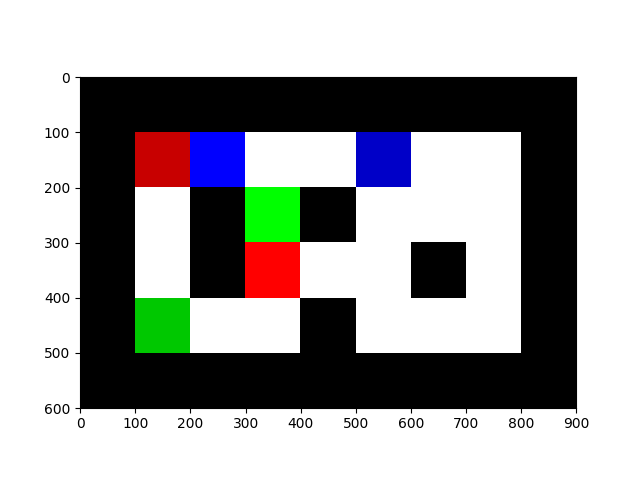

In [325]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob
%matplotlib nbagg

fig = plt.figure()

field_pathes = glob.glob("FieldData/*.png")
imgs = []
for i in range(len(field_pathes)):
    path = "FieldData/field_{0}.png".format(i)
    img = cv2.imread(path)
    imgs.append([plt.imshow(img)])
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000)

In [324]:
for best_action_data in all_best_action_data:
    for action_data in best_action_data:
        print(action_data)

[3, 3, 3]
[3, 3, 0]
[0, 3, 0]
[3, 3, 0]
[3, 2, 1]
[2, 2, 1]
[3, 2, 1]
[3, 3, 1]
[0, 3, 4]


# PreparationForSocket

In [225]:
import socket
TEST = True

## SetAGVNumber

In [226]:
def getAGVInfo(agv_num,option):
    if option =="send":
        port = 11220 + agv_num
    elif option == "get":
        port = 11330 + agv_num
    ip = "192.168.10." + str(11+agv_num)
    
    if TEST:
        port = 50007
        ip = "localhost"
    return port,ip

In [227]:
recieveData = recieveFeedBack(1)

NameError: name 'recieveFeedBack' is not defined

In [228]:
#Get current position from recieved data
def getCurrentPos(recieveData):
    recieveData = recieveData.decode('utf-8')
    print("recieveData = {0}".format(recieveData))
    #pos = [x_pos,y_pos]
    pos_str = [recieveData[13],recieveData[14:16],recieveData[17:20],recieveData[21],recieveData[22:24],recieveData[25:28]]
    print(pos_str)
    x_pos = int(pos_str[1]) + int(pos_str[2])*1e-3
    if pos_str[0] == "-":
        x_pos = -x_pos
    y_pos = int(pos_str[4]) + int(pos_str[5])*1e-3
    if pos_str[3] == "-":
        y_pos = -y_pos
    pos = [x_pos,y_pos]
    return pos

In [229]:
#Accept agv's recieve message
def recieveFeedBack(agv_num):
    port,ip = getAGVInfo(agv_num,"get")
    soc = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    soc.connect((ip,port))
    recieveData = soc.recv(1024)
    return recieveData

In [230]:
def translateData(action_data,agv_num):
    gridInterval = 2
    recieveData = recieveFeedBack(agv_num)
    current_pos = getCurrentPos(recieveData)
    print(current_pos)
    pos_data = []
    pos_data.append(current_pos)
    for action_list in action_data:
        action = action_list[agv_num-1]
        if action == 0:
            current_pos = [current_pos[0],current_pos[1]-gridInterval]
        elif action == 1:
            current_pos = [current_pos[0]+gridInterval,current_pos[1]]
        elif action == 2:
            current_pos = [current_pos[0],current_pos[1]+gridInterval]
        elif action == 3:
            current_pos = [current_pos[0]-gridInterval,current_pos[1]]
        print(current_pos)
        pos_data.append(current_pos)
    return pos_data

In [232]:
def translateIntoSendingData(pos_data):
    sendingData = "M:"
    for pos in pos_data:
        x_pos = pos[0]
        x_pos_str = str(x_pos)
        x_data = ""
        point_idx = x_pos_str.find(".")
        if x_pos_str[0] == "-":
            x_data = x_pos_str[0:point_idx]
        else:
            x_data = "+" + x_pos_str[0:point_idx]
        if len(x_data) != 3:
            x_data = x_data[0] + "0" + x_data[1]
        decimal = x_pos_str[point_idx:]
#         print(x_data)
        while len(decimal) < 4:
            decimal += "0"
        x_data = x_data + decimal
#         print("x_data = {0}".format(x_data))
        
        y_pos = pos[1]
        y_pos_str = str(y_pos)
        y_data = ""
        point_idx = y_pos_str.find(".")
        if y_pos_str[0] == "-":
            y_data = y_pos_str[0:point_idx]
        else:
            y_data = "+" + y_pos_str[0:point_idx]
        if len(y_data) != 3:
            y_data = y_data[0] + "0" + y_data[1]
        decimal = y_pos_str[point_idx:]
#         print(y_data)
        while len(decimal) < 4:
            decimal += "0"
        y_data = y_data + decimal
#         print("y_data = {0}".format(y_data))
        
        sendingData += x_data+ "," + y_data + ","
    sendingData += "1#100,0001,0100,0,0,0,0,0#" + x_data + "," + y_data + "\n"
    return sendingData

In [224]:
# print(all_best_action_data)
all_action_data = []
for action_data in all_best_action_data:
    for actions in action_data:
        all_action_data.append(list(actions))
print(all_action_data)

[[1, 0, 2], [1, 0, 2], [1, 0, 3], [1, 1, 3], [2, 1, 2], [1, 1, 3], [1, 1, 4], [1.0, 1.0, 3.0], [2.0, 1.0, 0.0], [2.0, 1.0, 0.0], [4.0, 4.0, 0.0], [0.0, 3.0, 0.0], [0.0, 2.0, 1.0], [3.0, 3.0, 1.0], [3.0, 2.0, 1.0], [4.0, 2.0, 1.0]]


In [233]:
all_data = []
for i in range(1,4):
    pos_data = translateData(all_action_data,i)
    data = translateIntoSendingData(pos_data)
    all_data.append(data)

ConnectionRefusedError: [Errno 111] Connection refused

In [252]:
import socket
def send(agv_num,all_action_data):
    port,ip = getAGVInfo(agv_num,"send")
    soc = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#     soc.connect(("192.168.10.12",11221))
    print("port,ip = {0},{1}".format(port,ip))
    soc.connect((ip,port))
    
#     data = "M:+00.000,+00.000,+02.000,+00.000,1,+02.000,-02.000,1,+00.000,-02.000,1,+00.000,+00.000,1#100,0001,0100,0,0,0,0,0#+10.000,+10.000\n"
    pos_data = translateData(all_action_data,agv_num)
    data = translateIntoSendingData(pos_data)
    print("sendingData = {0}".format(data))
    data = data.encode('utf-8')
    soc.send(data)
    
    recieveData = soc.recv(1024)
    print("recieveData = {0}".format(recieveData))
    confirm = ""
    if data == recieveData:
        confirm = "C:OK\n"
    else:
        confirm = "C:NG\n"
    print("confirm = {0}".format(confirm))
    confirm = confirm.encode('utf-8')
    soc.send(confirm)

In [235]:
for i in range(1,4):
    send(i,all_action_data)

recieveData = F:1519030157,+00.000,-00.000,+000.0,001

['+', '00', '000', '-', '00', '000']
[0.0, -0.0]
[0.0, -2.0]
[0.0, -4.0]
[0.0, -6.0]
[0.0, -8.0]
[-2.0, -8.0]
[-4.0, -8.0]
[-6.0, -8.0]
[-8.0, -8.0]
[-10.0, -8.0]
[-12.0, -8.0]
[-12.0, -6.0]
[-12.0, -6.0]
[-12.0, -4.0]
[-12.0, -2.0]
[-12.0, 0.0]
[-12.0, 2.0]
[-10.0, 2.0]
[-10.0, 2.0]
[-12.0, 2.0]
[-12.0, 0.0]
[-12.0, -2.0]
[-12.0, -4.0]
[-12.0, -6.0]
[-12.0, -6.0]
recieveData = b''
confirm = C:NG



BrokenPipeError: [Errno 32] Broken pipe

# TestActionData

In [245]:
# test_action_data = [[0,0,0],[0,0,0],[1,1,1]]
test_action_data = [[0,0,0]]

In [253]:
send(1,test_action_data)

port,ip = 11221,192.168.10.12


KeyboardInterrupt: 

In [ ]:
for i in range(1,4):
    send(i,test_action_data)

In [266]:
pos_str = ['+', '09', '899', '+', '09', '855']
x_pos = int(pos_str[1]) + int(pos_str[2])*1e-3
print(round(x_pos,3))

9.899


In [250]:
print(all_best_action_data)

[[array([ 0.,  0.,  2.]), array([ 3.,  3.,  2.]), array([ 3.,  3.,  3.]), array([ 3.,  0.,  3.]), array([ 3.,  0.,  2.]), array([ 3.,  1.,  3.]), array([ 4.,  1.,  3.])], [array([ 1.,  1.,  3.]), array([ 1.,  2.,  0.]), array([ 1.,  2.,  4.])], [[1, 2, 0], [1, 3, 0], [1, 3, 1], [2, 2, 4]]]


In [281]:
def modifyPosData(pos_data):
    for pos in pos_data:
        x_pos = pos[0]
        y_pos = pos[1]
        x_grid = int(x_pos / 1.8)
        y_grid = int(y_pos / 1.8)
        pos[0] = round(x_grid * 1.8 + 0.9,3)
        pos[1] = round(y_grid * 1.8 + 0.825,3)
    return pos_data

In [283]:
pos_data = [[1.248, 0.865],
[3.048, 0.865],
[4.848, 0.865],
[6.648, 0.865],
[8.448, 0.865],
[8.448, 2.665],
[10.248, 2.665],
[12.048, 2.665],
[12.048, 4.465],
[12.048, 6.265],
[12.048, 4.465],
[12.048, 2.665],
[10.248, 2.665],
[8.448, 2.665],
[8.448, 2.665]]
modifyPosData(pos_data)

[[0.9, 0.825],
 [2.7, 0.825],
 [4.5, 0.825],
 [6.3, 0.825],
 [8.1, 0.825],
 [8.1, 2.625],
 [9.9, 2.625],
 [11.7, 2.625],
 [11.7, 4.425],
 [11.7, 6.225],
 [11.7, 4.425],
 [11.7, 2.625],
 [9.9, 2.625],
 [8.1, 2.625],
 [8.1, 2.625]]